In [9]:
import pandas as pd
from urllib.parse import urlparse
import matplotlib.pyplot as plt


#### Small exmaple on the benign dataset

In [4]:
# Load the benign URLs
df = pd.read_csv("benign_dataframe_0.csv")  # assume column name is 'url'

In [5]:
df.sample(3)

,id,url,html
38,0080551f-0e5e-409b-81a2-4bfb9de182e8,https://goldprice.org/,PGh0bWwgbGFuZz0iZW4iIGRpcj0ibHRyIiBwcmVmaXg9Im...
623,07e043ef-6dd8-454c-abd1-338191dc6431,https://www.orange.ro/,PGh0bWwgbGFuZz0icm8iPjxoZWFkPjxtZXRhIGNoYXJzZX...
854,0af1460e-7e82-475f-8ef3-fd07a872c355,https://mtnews24.com/,PGh0bWwgbGFuZz0iZW4iPjxoZWFkPjxtZXRhIGh0dHAtZX...


In [6]:
df.shape

(1000, 3)

In [21]:
import re
from urllib.parse import urlparse
from collections import Counter
import math

def entropy(s):
    probs = [freq / len(s) for freq in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

def is_phishing_url(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname or ""
        tld = hostname.split('.')[-1]
        score = 0

        # Existing Heuristics
        subdomain = '.'.join(hostname.split('.')[:-2]) if len(hostname.split('.')) >= 3 else ''
        if len(subdomain) > 5:
            score += 0.2

        if any(fh in hostname for fh in ["weebly", "netlify", "000webhost", "github"]):
            score += 0.3

        if hostname.count('-') >= 1:
            score += 0.1

        if tld in ["tk", "ml", "ga", "cf", "gq"]:
            score += 0.2

        if any(k in url.lower() for k in ["login", "verify", "account", "secure", "update", "bank"]):
            score += 0.2

        # New Features 👇

        # 1. Long URL
        if len(url) > 75:
            score += 0.1

        # 2. Digit count in hostname
        digit_count = sum(c.isdigit() for c in hostname)
        if digit_count > 4:
            score += 0.1

        # 3. Entropy of hostname
        host_entropy = entropy(hostname)
        if host_entropy > 4.3:
            score += 0.1

        # 4. IP address as hostname
        if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', hostname):
            score += 0.2

        # 5. Special characters in the URL
        if any(c in url for c in ['%', '@', '&', '$']):
            score += 0.1

        return min(score, 1.0)

    except:
        return 0.0


Avg score: 0.021
Number flagged as phishing: 0


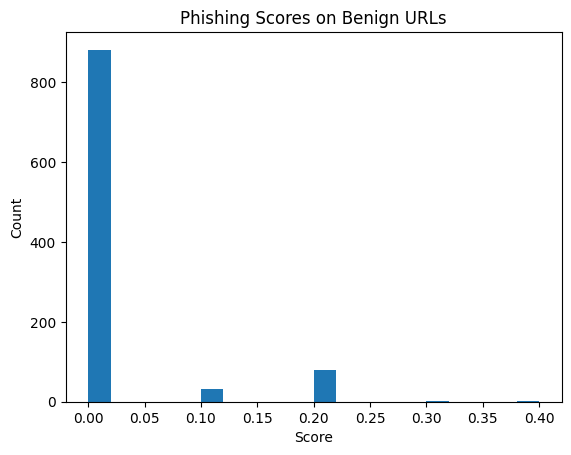

In [10]:
# Run it
df['phishing_score'] = df['url'].apply(is_phishing_url)

# Analyze false positives
print("Avg score:", df['phishing_score'].mean())
print("Number flagged as phishing:", (df['phishing_score'] > 0.7).sum())

# Optional: Plot histogram
plt.hist(df['phishing_score'], bins=20)
plt.title("Phishing Scores on Benign URLs")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

## Real-world dataset

#### Convert the index.sql to CSV
- https://data.mendeley.com/datasets/n96ncsr5g4/1

In [15]:
import re
import pandas as pd

# Set path to your .sql dump file
sql_path = "index.sql"  # Replace with your actual file path

# Read file contents
with open(sql_path, "r", encoding="utf-8") as f:
    content = f.read()

# Match all (rec_id, 'url', 'website', result, 'created_date') sets
pattern = re.findall(r"\((\d+),\s*'([^']+)',\s*'[^']*',\s*(\d),\s*'[^']*'\)", content)

# Build dataframe
df = pd.DataFrame(pattern, columns=["rec_id", "url", "label"])
df["rec_id"] = df["rec_id"].astype(int)
df["label"] = df["label"].astype(int)

# Save to CSV
df.to_csv("phishing_dataset_mendeley.csv", index=False)
print("✅ Extracted", len(df), "records to phishing_dataset.csv")


✅ Extracted 79987 records to phishing_dataset.csv


In [26]:
df.sample(3)

,rec_id,url,label,score,predicted
54801,54808,https://www.cloudflare.com/enterprise/,0,0.0,0
3,4,https://www.investopedia.com/terms/n/next-elev...,0,0.0,0
74672,74684,https://www.bigcommerce.com/blog/ecommerce-abo...,0,0.1,0


In [27]:
df.shape

(79987, 5)

### First version

In [ ]:
import re
from urllib.parse import urlparse
from collections import Counter
import math

def entropy(s):
    probs = [freq / len(s) for freq in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

def is_phishing_url(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname or ""
        tld = hostname.split('.')[-1]
        score = 0

        # Existing Heuristics
        subdomain = '.'.join(hostname.split('.')[:-2]) if len(hostname.split('.')) >= 3 else ''
        if len(subdomain) > 5:
            score += 0.2

        if any(fh in hostname for fh in ["weebly", "netlify", "000webhost", "github"]):
            score += 0.3

        if hostname.count('-') >= 1:
            score += 0.1

        if tld in ["tk", "ml", "ga", "cf", "gq"]:
            score += 0.2

        if any(k in url.lower() for k in ["login", "verify", "account", "secure", "update", "bank"]):
            score += 0.2

        # New Features 👇

        # 1. Long URL
        if len(url) > 75:
            score += 0.1

        # 2. Digit count in hostname
        digit_count = sum(c.isdigit() for c in hostname)
        if digit_count > 4:
            score += 0.1

        # 3. Entropy of hostname
        host_entropy = entropy(hostname)
        if host_entropy > 4.3:
            score += 0.1

        # 4. IP address as hostname
        if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', hostname):
            score += 0.2

        # 5. Special characters in the URL
        if any(c in url for c in ['%', '@', '&', '$']):
            score += 0.1

        return min(score, 1.0)

    except:
        return 0.0


Confusion Matrix:
 [[44772  5218]
 [15984 14013]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     49990
           1       0.73      0.47      0.57     29997

    accuracy                           0.73     79987
   macro avg       0.73      0.68      0.69     79987
weighted avg       0.73      0.73      0.72     79987

✅ Coverage (TPR): 0.4671
❌ Error Rate (FPR): 0.1044


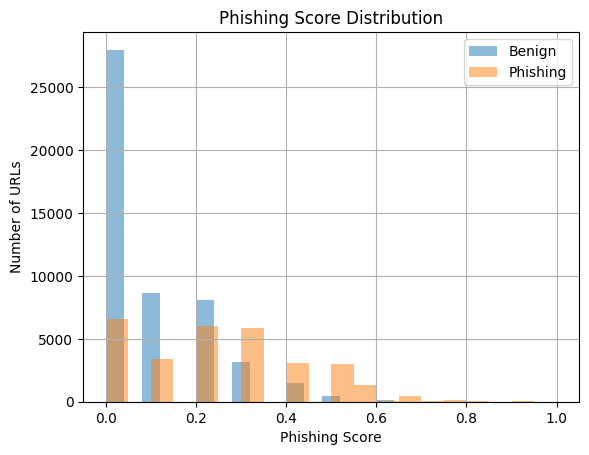

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# Apply scoring
df["score"] = df["url"].apply(is_phishing_url)
df["predicted"] = (df["score"] > 0.3).astype(int)

# Evaluation
y_true = df["label"]
y_pred = df["predicted"]

# Confusion Matrix: [ [TN, FP], [FN, TP] ]
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Coverage = True Positives / Total Phishing
coverage = tp / (tp + fn)

# Error Rate = False Positives / Total Benign
error_rate = fp / (fp + tn)

# Print classification summary
print("Confusion Matrix:\n", cm)
print(classification_report(y_true, y_pred))
print(f"✅ Coverage (TPR): {coverage:.4f}")
print(f"❌ Error Rate (FPR): {error_rate:.4f}")

# Plot score distribution
plt.hist(df[df["label"] == 0]["score"], bins=20, alpha=0.5, label='Benign')
plt.hist(df[df["label"] == 1]["score"], bins=20, alpha=0.5, label='Phishing')
plt.legend()
plt.xlabel("Phishing Score")
plt.ylabel("Number of URLs")
plt.title("Phishing Score Distribution")
plt.grid(True)
plt.show()


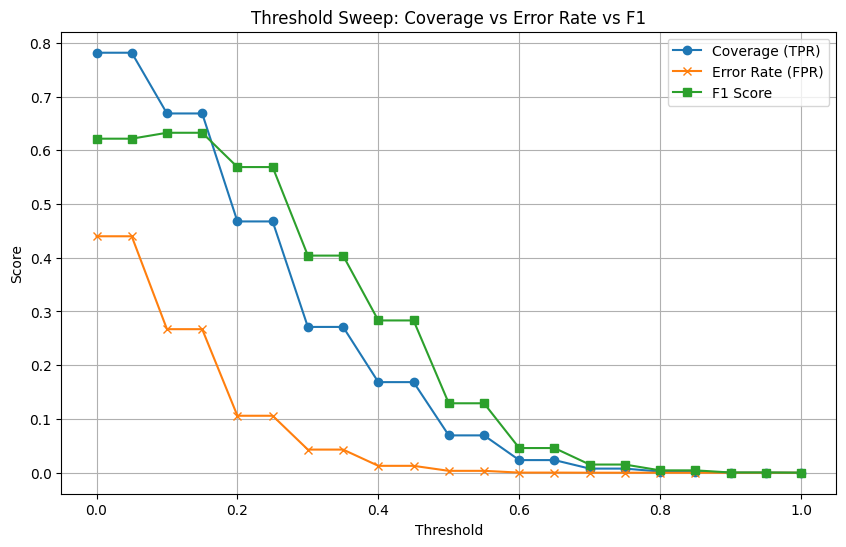

In [23]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
tpr_list = []
fpr_list = []
f1_list = []

y_true = df["label"]
scores = df["score"]

for threshold in thresholds:
    y_pred = (scores > threshold).astype(int)
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()

    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    f1 = f1_score(y_true, y_pred)

    tpr_list.append(tpr)
    fpr_list.append(fpr)
    f1_list.append(f1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr_list, label='Coverage (TPR)', marker='o')
plt.plot(thresholds, fpr_list, label='Error Rate (FPR)', marker='x')
plt.plot(thresholds, f1_list, label='F1 Score', marker='s')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sweep: Coverage vs Error Rate vs F1")
plt.legend()
plt.grid(True)
plt.show()


#### Let's try a bit more fancy rules

In [29]:
import re
from urllib.parse import urlparse
from collections import Counter
import math

def entropy(s):
    probs = [freq / len(s) for freq in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

def is_phishing_url(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname or ""
        tld = hostname.split('.')[-1]
        score = 0

        # 🌐 Structural
        subdomain = '.'.join(hostname.split('.')[:-2]) if len(hostname.split('.')) >= 3 else ''
        if len(subdomain) > 5:
            score += 0.2
        if len(url) > 75:
            score += 0.1
        if hostname.count('-') >= 1:
            score += 0.1
        digit_count = sum(c.isdigit() for c in hostname)
        if digit_count > 4:
            score += 0.1

        # 🧠 Lexical
        keywords = ["login", "verify", "account", "secure", "update", "bank"]
        if any(k in url.lower() for k in keywords):
            score += 0.2

        # 🌍 Hostname
        if any(fh in hostname for fh in ["weebly", "netlify", "000webhost", "github"]):
            score += 0.3
        if tld in ["tk", "ml", "ga", "cf", "gq"]:
            score += 0.2
        if entropy(hostname) > 4.3:
            score += 0.1
        if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', hostname):  # IP as domain
            score += 0.2

        # 🧪 NEW HEURISTICS
        if "@" in url:
            score += 0.2
        if parsed.port and parsed.port not in [80, 443]:
            score += 0.1
        if url.count('/') > 10:
            score += 0.1
        if len(parsed.query) > 50:
            score += 0.1
        if re.search(r'\.(exe|zip|rar)$', url.lower()):
            score += 0.2

        return min(score, 1.0)
    except:
        return 0.0


Confusion Matrix:
 [[45002  4988]
 [15753 14244]]
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     49990
           1       0.74      0.47      0.58     29997

    accuracy                           0.74     79987
   macro avg       0.74      0.69      0.70     79987
weighted avg       0.74      0.74      0.72     79987

✅ Coverage (TPR): 0.4748
❌ Error Rate (FPR): 0.0998


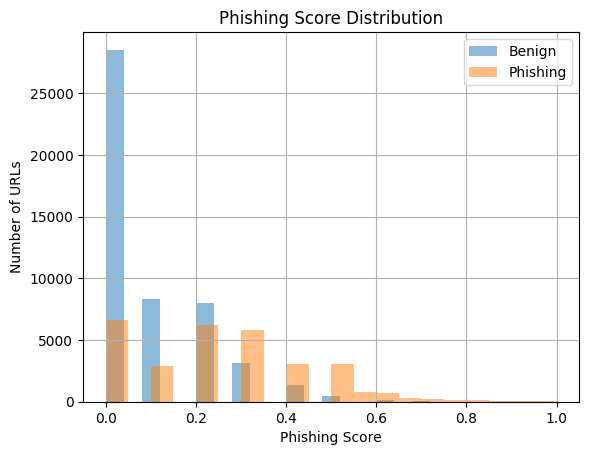

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Apply scoring
df["score"] = df["url"].apply(is_phishing_url)
df["predicted"] = (df["score"] > 0.3).astype(int)

# Evaluation
y_true = df["label"]
y_pred = df["predicted"]

# Confusion Matrix: [ [TN, FP], [FN, TP] ]
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Coverage = True Positives / Total Phishing
coverage = tp / (tp + fn)

# Error Rate = False Positives / Total Benign
error_rate = fp / (fp + tn)

# Print classification summary
print("Confusion Matrix:\n", cm)
print(classification_report(y_true, y_pred))
print(f"✅ Coverage (TPR): {coverage:.4f}")
print(f"❌ Error Rate (FPR): {error_rate:.4f}")

# Plot score distribution
plt.hist(df[df["label"] == 0]["score"], bins=20, alpha=0.5, label='Benign')
plt.hist(df[df["label"] == 1]["score"], bins=20, alpha=0.5, label='Phishing')
plt.legend()
plt.xlabel("Phishing Score")
plt.ylabel("Number of URLs")
plt.title("Phishing Score Distribution")
plt.grid(True)
plt.show()


#### It didn't really improve

## Let's try an ML-based solution. 
### Let's start with a decision tree

In [34]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from urllib.parse import urlparse
import math
import re

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the phishing dataset
df = pd.read_csv("phishing_dataset_mendeley.csv")  # Make sure this file exists in your working directory

train_df, val_df = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df["label"]
)

# Save to CSV
train_df.to_csv("train_urls.csv", index=False)
val_df.to_csv("val_urls.csv", index=False)

print("✅ Split completed:")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

# print how many phishing and benign URLs are in the training set
print("Training set:")
print(train_df["label"].value_counts())
print("Validation set:")
print(val_df["label"].value_counts())


✅ Split completed:
Train size: 71988
Validation size: 7999
Training set:
label
0    44991
1    26997
Name: count, dtype: int64
Validation set:
label
0    4999
1    3000
Name: count, dtype: int64


#### First, we'll need to extract the features

In [35]:

# 1. Feature Extractor
def entropy(s):
    probs = [freq / len(s) for freq in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

def extract_url_features(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname or ""
        tld = hostname.split('.')[-1] if '.' in hostname else ''
        subdomain = '.'.join(hostname.split('.')[:-2]) if len(hostname.split('.')) >= 3 else ''
        query = parsed.query or ''
        path = parsed.path or ''

        features = {
            "url_length": len(url),
            "hostname_length": len(hostname),
            "subdomain_length": len(subdomain),
            "num_digits": sum(c.isdigit() for c in hostname),
            "num_hyphens": hostname.count('-'),
            "num_tokens": len(hostname.split('.')),
            "num_slashes": url.count('/'),
            "has_at_symbol": int('@' in url),
            "has_ip_address": int(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', hostname) is not None),
            "is_free_hosting": int(any(fh in hostname for fh in ["weebly", "netlify", "000webhost", "github"])),
            "has_suspicious_port": int(parsed.port not in [None, 80, 443]),
            "has_exe_or_zip": int(bool(re.search(r'\.(exe|zip|rar)$', url.lower()))),
            "has_long_query": int(len(query) > 50),
            "has_keywords": int(any(k in url.lower() for k in ["login", "verify", "account", "secure", "update", "bank"])),
            "has_suspicious_tld": int(tld in ["tk", "ml", "ga", "cf", "gq"]),
            "high_entropy_domain": int(entropy(hostname) > 4.3),
        }
        return features
    except:
        return {k: 0 for k in [
            "url_length", "hostname_length", "subdomain_length", "num_digits", "num_hyphens",
            "num_tokens", "num_slashes", "has_at_symbol", "has_ip_address", "is_free_hosting",
            "has_suspicious_port", "has_exe_or_zip", "has_long_query", "has_keywords",
            "has_suspicious_tld", "high_entropy_domain"
        ]}

In [69]:
from itertools import product
from sklearn.tree import export_text
from sklearn.tree import plot_tree

# --- Pipeline Function ---
def run_pipeline(train_df, val_df, param_grid, extract_url_features_func, plot_tree=False):

    # 2. Extract features using the enhanced feature extractor
    X_train = train_df["url"].apply(extract_url_features_func).apply(pd.Series)
    y_train = train_df["label"]
    X_val = val_df["url"].apply(extract_url_features_func).apply(pd.Series)
    y_val = val_df["label"]
    
    # 3. Hyperparameter Tuning: Grid Search
    results = []
    for max_depth, min_samples_leaf, criterion in product(*param_grid.values()):
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        cm = confusion_matrix(y_val, y_pred)
        if cm.shape == (2,2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0
        tpr = tp / (tp + fn) if (tp + fn) else 0  # Coverage (Recall for phishing)
        fpr = fp / (fp + tn) if (fp + tn) else 0  # Error rate
        f1 = f1_score(y_val, y_pred)
        
        print(f"Max Depth: {max_depth}, Min Samples Leaf: {min_samples_leaf}, Criterion: {criterion}")
        print(f"TPR (Coverage): {tpr:.4f}, FPR (Error Rate): {fpr:.4f}, F1: {f1:.4f}")
        print("\n")
        results.append({
            "max_depth": max_depth,
            "min_samples_leaf": min_samples_leaf,
            "criterion": criterion,
            "F1": round(f1, 4),
            "TPR (Coverage)": round(tpr, 4),
            "FPR (Error Rate)": round(fpr, 4)
        })
    
    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by="F1", ascending=False)
    
    # Plot TPR vs FPR colored by F1 Score
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(results_df["FPR (Error Rate)"], results_df["TPR (Coverage)"], c=results_df["F1"], cmap='viridis', s=100)
    plt.colorbar(sc, label="F1 Score")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR / Coverage)")
    plt.title("Hyperparameter Tuning: TPR vs FPR (Colored by F1 Score)")
    plt.grid(True)
    plt.show()
    
    # Print top configurations and select the best one by F1
    print("🔝 Top 5 Configurations by F1 Score:")
    print(results_df_sorted.head())
    best_config = results_df_sorted.iloc[0]
    print("\n✅ Best Configuration by F1 Score:")
    print(best_config)
    
    # 4. Train final model with best config on the training set
    best_model = DecisionTreeClassifier(
        max_depth=int(best_config["max_depth"]),
        min_samples_leaf=int(best_config["min_samples_leaf"]),
        criterion=best_config["criterion"],
        random_state=42
    )
    best_model.fit(X_train, y_train)
    y_pred_final = best_model.predict(X_val)
    
    # 5. Final Evaluation
    final_cm = confusion_matrix(y_val, y_pred_final)
    final_report = classification_report(y_val, y_pred_final, output_dict=True)
    final_report_df = pd.DataFrame(final_report).transpose()
    
    print("\n📊 Final Confusion Matrix:\n", final_cm)
    print("\n📋 Final Classification Report:\n", final_report_df)
    
    # print coverage and error rate
    tn, fp, fn, tp = final_cm.ravel()
    coverage = tp / (tp + fn) if (tp + fn) else 0
    error_rate = fp / (fp + tn) if (fp + tn) else 0
    print(f"✅ Final Coverage (TPR): {coverage:.4f}")
    print(f"❌ Final Error Rate (FPR): {error_rate:.4f}")
    
    if plot_tree:
        # 6. Visualize the Decision Tree
        plt.figure(figsize=(12, 8))
        plot_tree(best_model, feature_names=list(X_train.columns), filled=True, rounded=True)
        plt.show()

    # Get feature names and importances
    feature_names = list(X_train.columns)
    importances = best_model.feature_importances_

    # Sort by importance
    sorted_idx = importances.argsort()[::-1]
    sorted_names = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_names[::-1], sorted_importances[::-1])  # Plot most important at top
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance of Decision Tree")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return best_model, best_config, results_df_sorted


Max Depth: 5, Min Samples Leaf: 5, Criterion: gini
TPR (Coverage): 0.6483, FPR (Error Rate): 0.1072, F1: 0.7097


Max Depth: 5, Min Samples Leaf: 10, Criterion: gini
TPR (Coverage): 0.6483, FPR (Error Rate): 0.1072, F1: 0.7097


Max Depth: 5, Min Samples Leaf: 20, Criterion: gini
TPR (Coverage): 0.6483, FPR (Error Rate): 0.1072, F1: 0.7097


Max Depth: 10, Min Samples Leaf: 5, Criterion: gini
TPR (Coverage): 0.6607, FPR (Error Rate): 0.0518, F1: 0.7563


Max Depth: 10, Min Samples Leaf: 10, Criterion: gini
TPR (Coverage): 0.6637, FPR (Error Rate): 0.0530, F1: 0.7576


Max Depth: 10, Min Samples Leaf: 20, Criterion: gini
TPR (Coverage): 0.6597, FPR (Error Rate): 0.0524, F1: 0.7552


Max Depth: 15, Min Samples Leaf: 5, Criterion: gini
TPR (Coverage): 0.7273, FPR (Error Rate): 0.0766, F1: 0.7842


Max Depth: 15, Min Samples Leaf: 10, Criterion: gini
TPR (Coverage): 0.7310, FPR (Error Rate): 0.0810, F1: 0.7835


Max Depth: 15, Min Samples Leaf: 20, Criterion: gini
TPR (Coverage): 0.7317, F

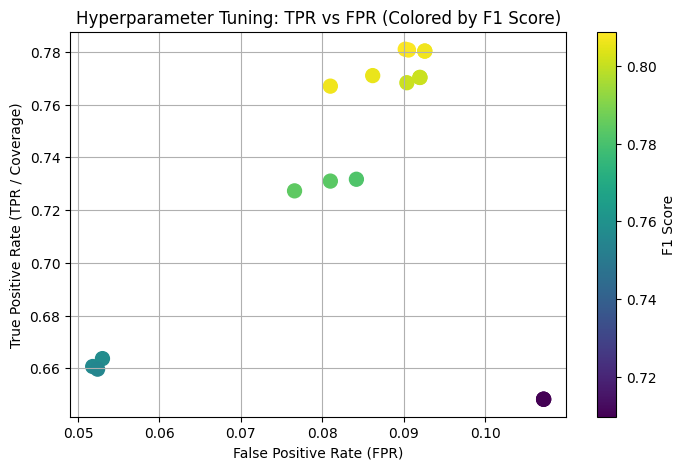

🔝 Top 5 Configurations by F1 Score:
    max_depth  min_samples_leaf criterion      F1  TPR (Coverage)  \
12         30                 5      gini  0.8088          0.7810   
15         40                 5      gini  0.8083          0.7807   
13         30                10      gini  0.8067          0.7803   
16         40                10      gini  0.8067          0.7803   
9          20                 5      gini  0.8065          0.7670   

    FPR (Error Rate)  
12            0.0902  
15            0.0906  
13            0.0926  
16            0.0926  
9             0.0810  

✅ Best Configuration by F1 Score:
max_depth               30
min_samples_leaf         5
criterion             gini
F1                  0.8088
TPR (Coverage)       0.781
FPR (Error Rate)    0.0902
Name: 12, dtype: object

📊 Final Confusion Matrix:
 [[4548  451]
 [ 657 2343]]

📋 Final Classification Report:
               precision    recall  f1-score      support
0              0.873775  0.909782  0.891415  

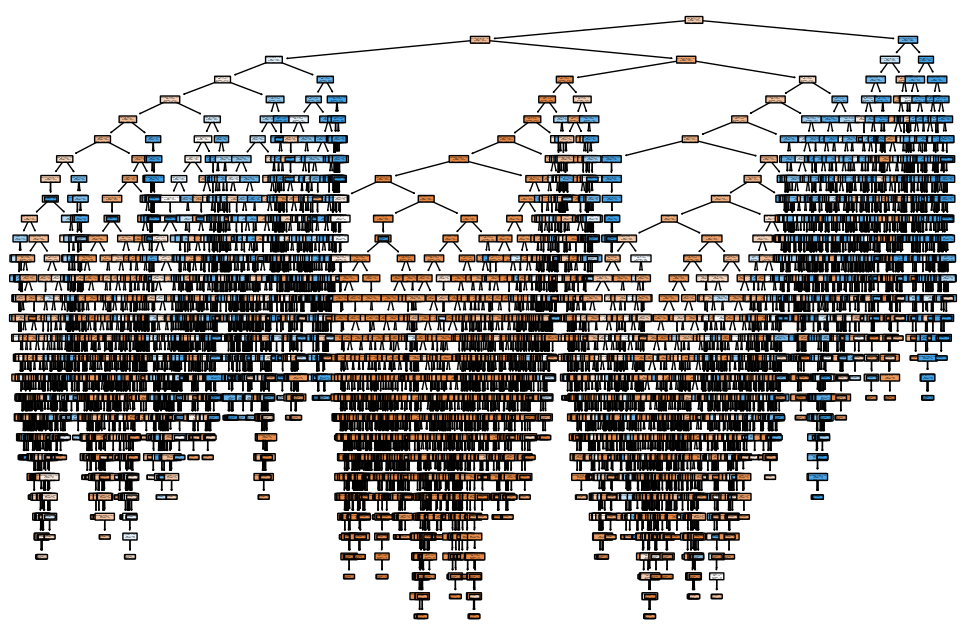

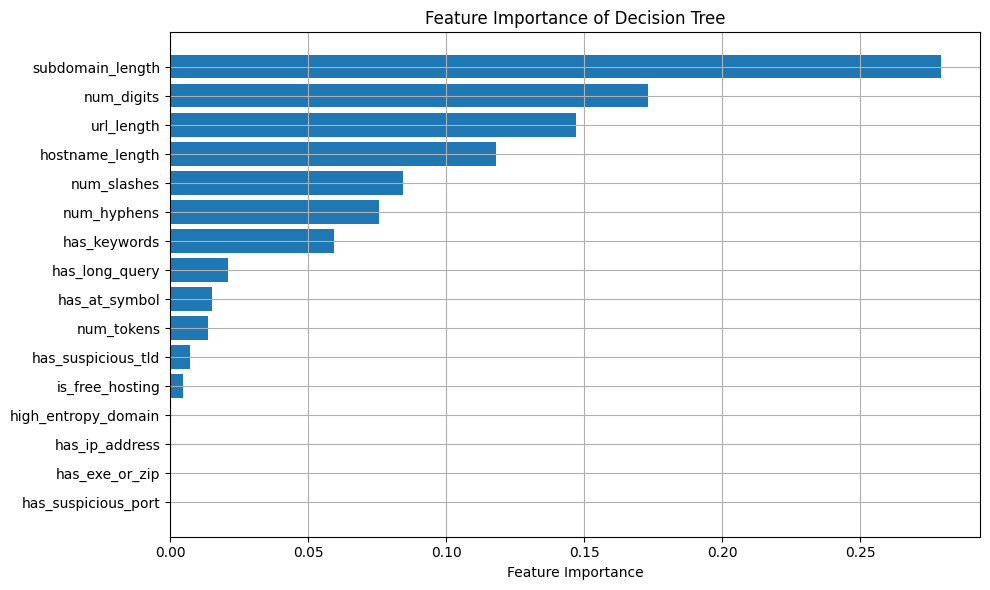

In [67]:

# --- Example usage ---
# Define the hyperparameter grid
param_grid = {
    "max_depth": [5, 10, 20, 30],
    "min_samples_leaf": [5, 10, 20],
    "criterion": ["gini"]
}

# Run the pipeline; adjust file paths as needed
best_model, best_config, tuning_results = run_pipeline(train_df, val_df, param_grid, extract_url_features)

### let's extract more features

In [55]:
def extract_url_features_v2(url):
    try:
        parsed = urlparse(url)
        hostname = parsed.hostname or ""
        tld = hostname.split('.')[-1] if '.' in hostname else ''
        subdomain = '.'.join(hostname.split('.')[:-2]) if len(hostname.split('.')) >= 3 else ''
        query = parsed.query or ''
        path = parsed.path or ''

        query_params = query.split('&') if query else []

        # New keyword checks
        path_keywords = ["reset", "secure", "auth", "confirm"]
        suspicious_extensions = [".php", ".asp", ".cgi", ".jsp", ".exe"]

        return {
            # Previous base features
            "url_length": len(url),
            "hostname_length": len(hostname),
            "subdomain_length": len(subdomain),
            "num_digits": sum(c.isdigit() for c in hostname),
            "num_hyphens": hostname.count('-'),
            "num_tokens": len(hostname.split('.')),
            "num_slashes": url.count('/'),
            "has_at_symbol": int('@' in url),
            "has_ip_address": int(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', hostname) is not None),
            "is_free_hosting": int(any(fh in hostname for fh in ["weebly", "netlify", "000webhost", "github"])),
            "has_suspicious_port": int(parsed.port not in [None, 80, 443]),
            "has_exe_or_zip": int(bool(re.search(r'\.(exe|zip|rar)$', url.lower()))),
            "has_long_query": int(len(query) > 50),
            "has_keywords": int(any(k in url.lower() for k in ["login", "verify", "account", "secure", "update", "bank"])),
            "has_suspicious_tld": int(tld in ["tk", "ml", "ga", "cf", "gq"]),
            "high_entropy_domain": int(entropy(hostname) > 4.3),

            # ✅ New features
            "is_numeric_domain": int(re.match(r'^\d+$', hostname.replace('.', '').replace('-', '')) is not None),
            "domain_ends_with_number": int(re.search(r'\d$', hostname.split('.')[-2]) is not None),
            "path_contains_keywords": int(any(k in path.lower() for k in path_keywords)),
            "filename_suspicious_ext": int(any(path.lower().endswith(ext) for ext in suspicious_extensions)),
            "num_query_params": len(query_params)
        }
    except:
        return {k: 0 for k in [
            "url_length", "hostname_length", "subdomain_length", "num_digits", "num_hyphens",
            "num_tokens", "num_slashes", "has_at_symbol", "has_ip_address", "is_free_hosting",
            "has_suspicious_port", "has_exe_or_zip", "has_long_query", "has_keywords",
            "has_suspicious_tld", "high_entropy_domain", "is_numeric_domain",
            "domain_ends_with_number", "path_contains_keywords", "filename_suspicious_ext", "num_query_params"
        ]}


Max Depth: 5, Min Samples Leaf: 5, Criterion: gini
TPR (Coverage): 0.6257, FPR (Error Rate): 0.0692, F1: 0.7187


Max Depth: 5, Min Samples Leaf: 10, Criterion: gini
TPR (Coverage): 0.6257, FPR (Error Rate): 0.0692, F1: 0.7187


Max Depth: 5, Min Samples Leaf: 20, Criterion: gini
TPR (Coverage): 0.6257, FPR (Error Rate): 0.0692, F1: 0.7187


Max Depth: 10, Min Samples Leaf: 5, Criterion: gini
TPR (Coverage): 0.7317, FPR (Error Rate): 0.0624, F1: 0.7972


Max Depth: 10, Min Samples Leaf: 10, Criterion: gini
TPR (Coverage): 0.7300, FPR (Error Rate): 0.0636, F1: 0.7952


Max Depth: 10, Min Samples Leaf: 20, Criterion: gini
TPR (Coverage): 0.7370, FPR (Error Rate): 0.0674, F1: 0.7970


Max Depth: 20, Min Samples Leaf: 5, Criterion: gini
TPR (Coverage): 0.8063, FPR (Error Rate): 0.0726, F1: 0.8367


Max Depth: 20, Min Samples Leaf: 10, Criterion: gini
TPR (Coverage): 0.7990, FPR (Error Rate): 0.0752, F1: 0.8304


Max Depth: 20, Min Samples Leaf: 20, Criterion: gini
TPR (Coverage): 0.7943, F

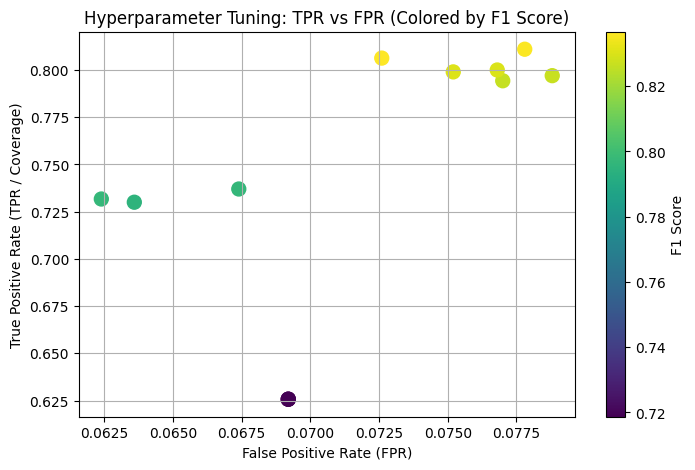

🔝 Top 5 Configurations by F1 Score:
    max_depth  min_samples_leaf criterion      F1  TPR (Coverage)  \
6          20                 5      gini  0.8367          0.8063   
9          30                 5      gini  0.8358          0.8110   
7          20                10      gini  0.8304          0.7990   
10         30                10      gini  0.8299          0.8000   
11         30                20      gini  0.8266          0.7970   

    FPR (Error Rate)  
6             0.0726  
9             0.0778  
7             0.0752  
10            0.0768  
11            0.0788  

✅ Best Configuration by F1 Score:
max_depth               20
min_samples_leaf         5
criterion             gini
F1                  0.8367
TPR (Coverage)      0.8063
FPR (Error Rate)    0.0726
Name: 6, dtype: object

📊 Final Confusion Matrix:
 [[4636  363]
 [ 581 2419]]

📋 Final Classification Report:
               precision    recall  f1-score      support
0              0.888633  0.927385  0.907596  4

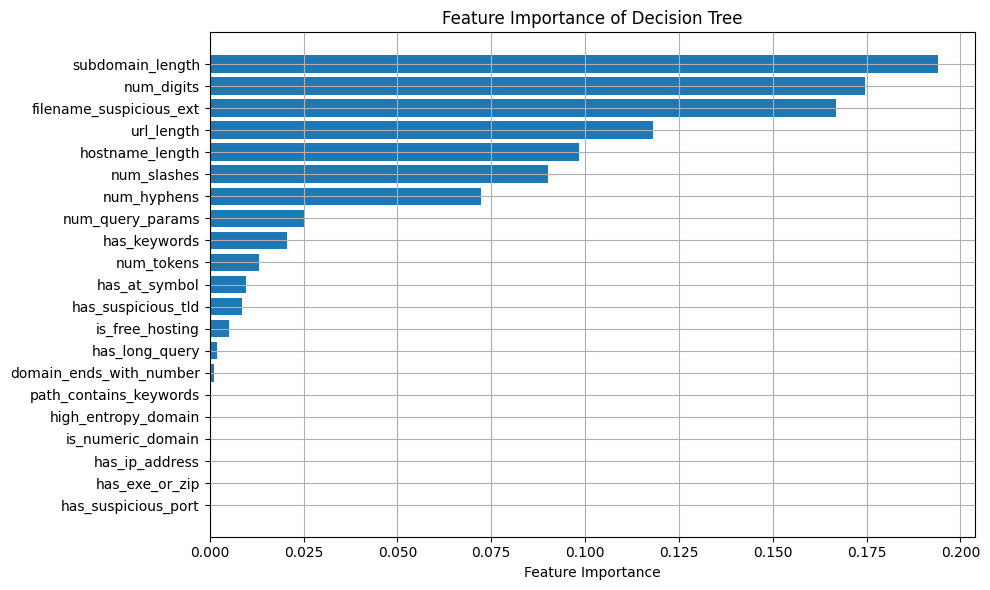

In [70]:

# --- Example usage ---
# Define the hyperparameter grid
param_grid = {
    "max_depth": [5, 10, 20, 30],
    "min_samples_leaf": [5, 10, 20],
    "criterion": ["gini"]
}

# Run the pipeline; adjust file paths as needed
best_model, best_config, tuning_results = run_pipeline(train_df, val_df, param_grid, extract_url_features_v2)